In [1]:
from glob import glob
import os
import pickle
import json
from configparser import ConfigParser
import operator
import itertools

import tensorflow as tf
from sklearn import metrics
import joblib
import numpy as np
from scipy.sparse import coo_matrix
from scipy import optimize
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

## Results

### Framewise error rate

In [8]:
root = '/media/ildefonso/HD-LCU3/tf_syl_seg/koumura_repo_results/'
these_dirs_branch = [
    ('results_181014_194418', 'bird 0'),
    ('results_181015_075005', 'bird 1'),
    ('results_181014_194508', 'bird 2'),
    #('results_180306_145149', 'bird 3'),
    #('results_180308_134732', 'bird 4'),
    ('results_181017_105732', 'bird 5'),
    ('results_181016_010102', 'bird 6'),
    ('results_181016_074937', 'bird 7'),
    ('results_181015_103121', 'bird 9')
]

these_dirs = [(root + this_dir[0], this_dir[1]) for this_dir in these_dirs_branch]

In [9]:
config = ConfigParser()

all_results_list = []

for this_dir, bird_ID in these_dirs:
    results_dict = {}
    results_dict['dir'] = this_dir
    os.chdir(this_dir)
    config.read(glob('config*')[0])
    results_dict['data_dir'] = config['DATA']['data_dir']
    results_dict['time_steps'] = config['NETWORK']['time_steps']
    results_dict['num_hidden'] = config['NETWORK']['num_hidden']
    results_dict['train_set_durs'] = [int(element)
                      for element in
                      config['TRAIN']['train_set_durs'].split(',')]
    with open(glob('summary*/train_err')[0], 'rb') as f:
        results_dict['train_err'] = pickle.load(f)
    with open(glob('summary*/test_err')[0], 'rb') as f:
        results_dict['test_err'] = pickle.load(f)
    pe = joblib.load(glob('summary*/y_preds_and_err_for_train_and_test')[0])
    results_dict['train_syl_err_rate'] = pe['train_syl_err_rate']
    results_dict['test_syl_err_rate'] = pe['test_syl_err_rate']
    results_dict['bird_ID'] = bird_ID
    all_results_list.append(results_dict)
    os.chdir('..')


for el in all_results_list:
    el['mn_test_err'] = np.mean(el['test_err'], axis=1)
    el['mn_train_err'] = np.mean(el['train_err'], axis=1)
    el['mn_train_syl_err'] = np.mean(el['train_syl_err_rate'], axis=1)
    el['mn_test_syl_err'] = np.mean(el['test_syl_err_rate'], axis=1)
    el['train_set_durs'] = np.asarray(el['train_set_durs'])

plot framewise error

In [10]:
all_mn_test_err = []
for el in all_results_list:
    all_mn_test_err.append(el['mn_test_err'])
all_mn_test_err = np.asarray(all_mn_test_err)

In [37]:
plt.yticks?

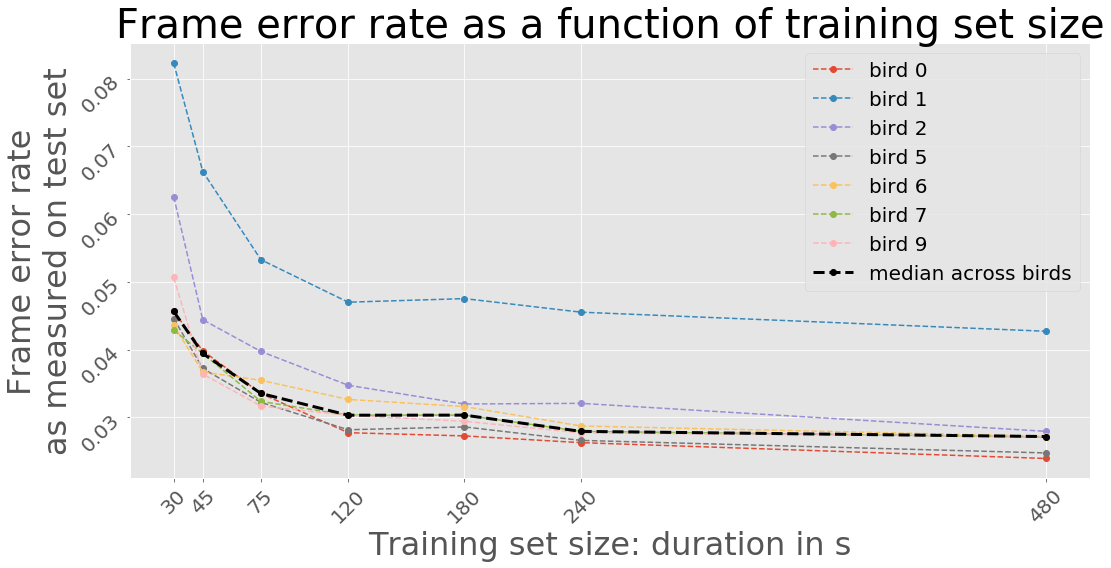

In [79]:
plt.style.use('ggplot')
fig, ax = plt.subplots()
for el in all_results_list:
    lbl = (el['bird_ID'])
    ax.plot(el['train_set_durs'],
            el['mn_test_err'],
            label=lbl,
            linestyle='--',
           marker='o')
ax.plot(el['train_set_durs'],np.median(all_mn_test_err,axis=0),
        linestyle='--',marker='o',linewidth=3,color='k',label='median across birds')

fig.set_size_inches(16,8)
plt.legend(fontsize=20)
plt.xticks(el['train_set_durs'])
plt.tick_params(axis='both', which='major', labelsize=20, rotation=45)
plt.title('Frame error rate as a function of training set size', fontsize=40)
plt.ylabel('Frame error rate\nas measured on test set', fontsize=32)
plt.xlabel('Training set size: duration in s', fontsize=32);
plt.tight_layout()
plt.savefig('frame-err-rate-v-train-set-size.png')

### syllable error rate

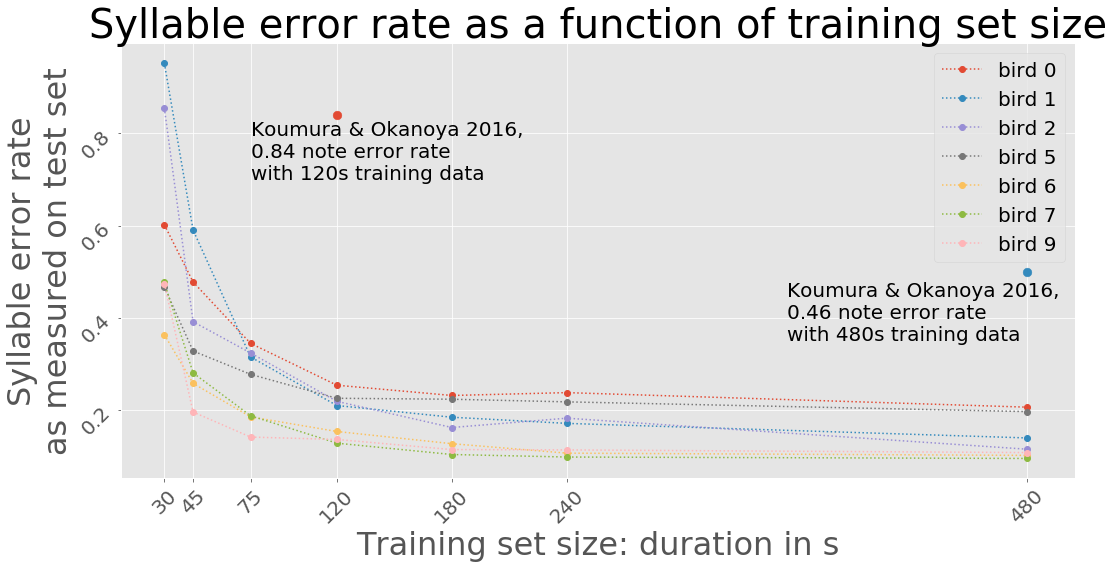

In [81]:
plt.style.use('ggplot')
fig, ax = plt.subplots()
fig.set_size_inches(16,8)
for el in all_results_list:
    lbl = (el['bird_ID'])
    ax.plot(el['train_set_durs'],
            el['mn_test_syl_err'],
            label=lbl,
            linestyle=':',
           marker='o')

plt.scatter(120,0.84,s=75)
plt.text(75,0.7,'Koumura & Okanoya 2016,\n0.84 note error rate\nwith 120s training data', fontsize=20)
plt.scatter(480,0.5,s=75)
plt.text(355,0.35,'Koumura & Okanoya 2016,\n0.46 note error rate\nwith 480s training data', fontsize=20)
    
plt.legend(fontsize=20, loc='upper right');
plt.title('Syllable error rate as a function of training set size', fontsize=40)
plt.xticks(el['train_set_durs'])
plt.tick_params(axis='both', which='major', labelsize=20, rotation=45)
plt.ylabel('Syllable error rate\nas measured on test set', fontsize=32)
plt.xlabel('Training set size: duration in s', fontsize=32);
plt.tight_layout()
plt.savefig('syl-error-rate-v-train-set-size.png')